# Task 2

---

## Predictive modeling of customer bookings

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
importance_threshold = 0.02

In [2]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

In [8]:
# Prepare the dataset for predictive rf_modeling
# Convert categorical variables to numerical using one-hot encoding
df_encoded = pd.get_dummies(df)

# Split the dataset into training and testing sets
X = df_encoded.drop('booking_complete', axis=1)
y = df_encoded['booking_complete']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
# Evaluate the rf_model
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      8520
           1       0.52      0.14      0.23      1480

    accuracy                           0.85     10000
   macro avg       0.69      0.56      0.57     10000
weighted avg       0.82      0.85      0.82     10000



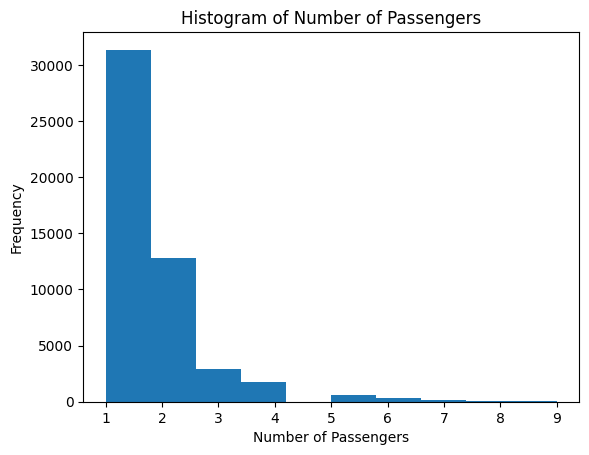

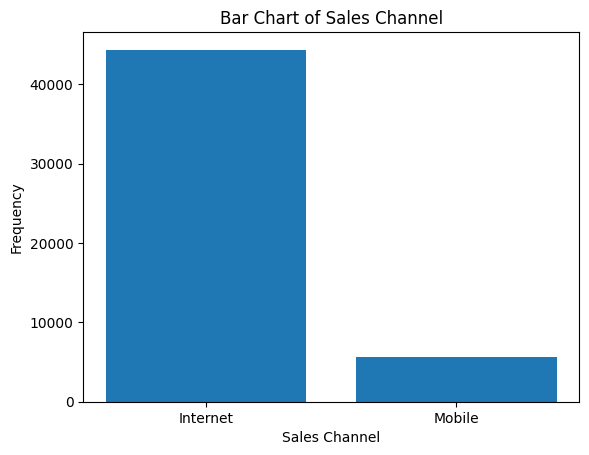

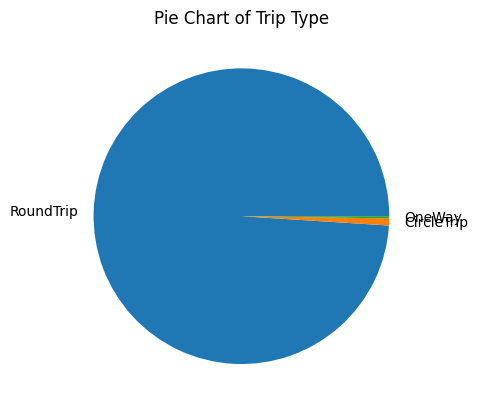

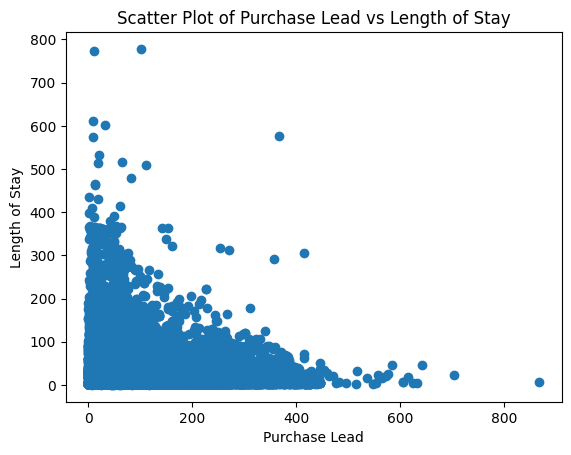

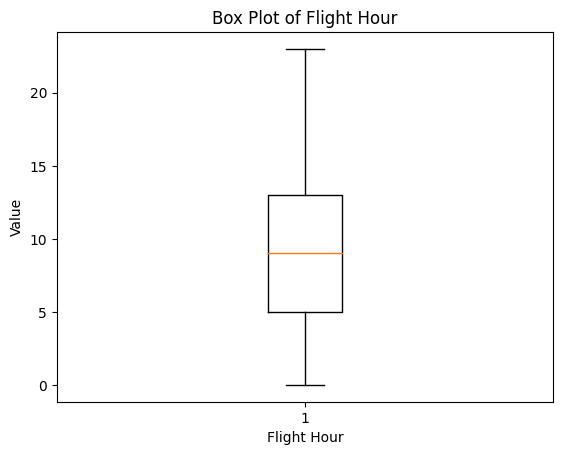

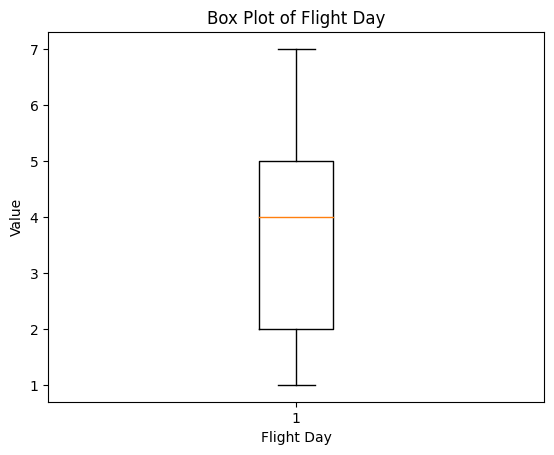

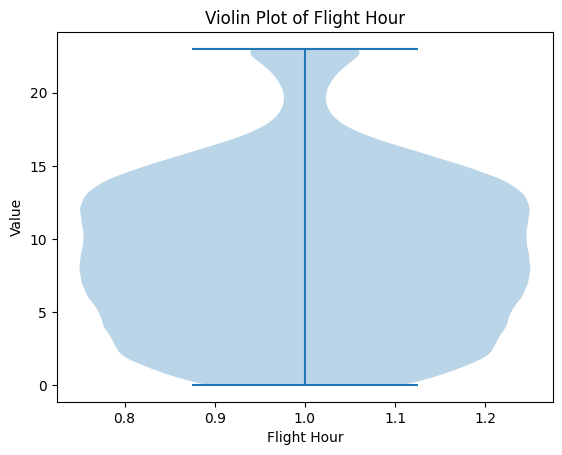

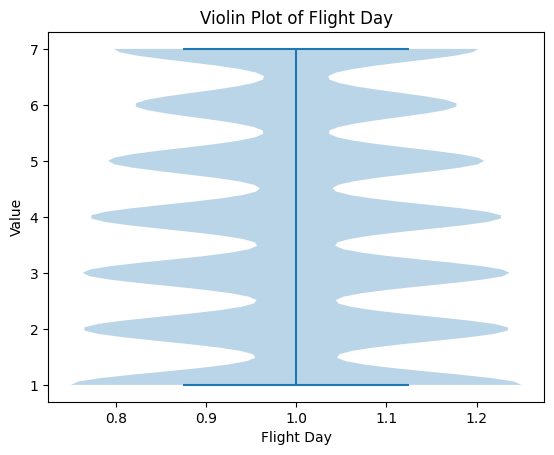

In [11]:
# Plot a histogram of the number of passengers
plt.hist(df['num_passengers'], label='Number of Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Passengers')
plt.show()

# Plot a bar chart of the sales channel
plt.bar(df['sales_channel'].unique(), df['sales_channel'].value_counts(), label='Sales Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Frequency')
plt.title('Bar Chart of Sales Channel')
plt.show()

# Plot a pie chart of the trip type
plt.pie(df['trip_type'].value_counts(), labels=df['trip_type'].unique())
plt.title('Pie Chart of Trip Type')
plt.show()

# Plot a scatter plot of the purchase lead and length of stay
plt.scatter(df['purchase_lead'], df['length_of_stay'], label='Purchase Lead vs Length of Stay')
plt.xlabel('Purchase Lead')
plt.ylabel('Length of Stay')
plt.title('Scatter Plot of Purchase Lead vs Length of Stay')
plt.show()

# Plot a box plot of the flight hour
fig, ax = plt.subplots()
ax.boxplot(df['flight_hour'])
ax.set_xlabel('Flight Hour')
ax.set_ylabel('Value')
ax.set_title('Box Plot of Flight Hour')
plt.show()

# Plot a box plot of the flight day
fig, ax = plt.subplots()
ax.boxplot(df['flight_day'])
ax.set_xlabel('Flight Day')
ax.set_ylabel('Value')
ax.set_title('Box Plot of Flight Day')
plt.show()

# Plot a violin plot of the flight hour
fig, ax = plt.subplots()
ax.violinplot(df['flight_hour'])
ax.set_xlabel('Flight Hour')
ax.set_ylabel('Value')
ax.set_title('Violin Plot of Flight Hour')
plt.show()

# Plot a violin plot of the flight day
fig, ax = plt.subplots()
ax.violinplot(df['flight_day'])
ax.set_xlabel('Flight Day')
ax.set_ylabel('Value')
ax.set_title('Violin Plot of Flight Day')
plt.show()


In [18]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Evaluate the model using cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

# Output evaluation metrics
print("Cross-validation scores:")
print(cv_scores)
print("Mean CV Score:", np.mean(cv_scores))
print("Standard Deviation of CV Scores:", np.std(cv_scores))


Cross-validation scores:
[0.846375 0.850375 0.85     0.845    0.8555  ]
Mean CV Score: 0.84945
Standard Deviation of CV Scores: 0.0036611132186809173


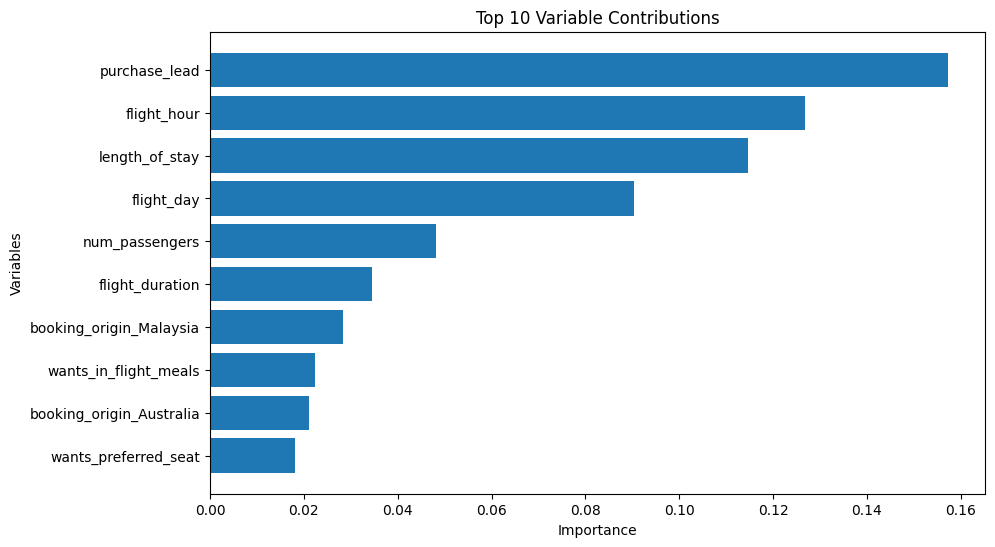

In [17]:
N = 10  # Number of top variables to display
plt.figure(figsize=(10, 6))
plt.barh(range(N), feature_importances[sorted_indices][-N:], align='center')
plt.yticks(range(N), X_train.columns[sorted_indices][-N:])
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.title('Top {} Variable Contributions'.format(N))
plt.show()
